In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Initialize variables required for the algorithm

learning_rate = 2e-2    # initial learning rate
Kx = 10
Ky = 10
#n_hidden = Kx*Ky        # number of hidden units that are displayed in Ky by Kx array
n_hidden = 2000
mu = 0.0                # mean for gaussian distribution to initialize weights with
sigma = 1.0             # standard deviation for gaussian distribution to initialize weights with
n_epochs = 200          # number of epochs
batch_size = 100        # size of the minibatch
precision = 1e-30       # parameter to control numerical precision of weight updates
anti_hebbian_learning_strength = 0.4    # Strength of the anti-hebbian learning
lebesgue_norm = 2.0                     # Lebesgue norm of the weights
rank = 2                                # ranking parameter, must be integer that is bigger or equal than 2

In [4]:
# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Define function that performs the unsupervised learning and returns weights
# that correspond to feature detectors.
# Uses cuda if available.
def get_unsupervised_weights(data, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                             anti_hebbian_learning_strength, lebesgue_norm, rank):
    print("Starting unsupervised bio-plausible training")
    
    num_samples = data.shape[0]   # Number of samples/images.
    num_features = data.shape[1]  # Number of pixels for each sample/image.
    
    # Initialize weights to be values drawn from gaussian distribution.
    synapses = np.random.normal(mu, sigma, (n_hidden, num_features)).astype(np.float32)
    weights = torch.from_numpy(synapses).to(device)

    # The external loop runs over epochs
    for epoch in range(n_epochs):
        eps = learning_rate * (1 - epoch / n_epochs)

        # Scramble the images and values. So that when making a
        # mini batch, random values/images will be chosen on each iteration.
        random_permutation_samples = np.random.permutation(num_samples)
        shuffled_epoch_data = data[random_permutation_samples,:]

        # Internal loop runs over minibatches    
        for i in range(num_samples // batch_size):        
            # For every minibatch the overlap with the data (tot_input) is 
            # calculated for each data point and each hidden unit.
            mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
            mini_batch = torch.from_numpy(mini_batch).to(device)           
            mini_batch = torch.transpose(mini_batch, 0, 1)

            sign = torch.sign(weights)            
            W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
            # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
            tot_input_torch = torch.mm(W, mini_batch)

            # The sorted strengths of the activations are stored in y. 
            # The variable yl stores the activations of the post synaptic cells - 
            # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
            y_torch = torch.argsort(tot_input_torch, dim=0)            
            yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
            yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
            yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength

            # The variable ds is the right hand side of Eq 3        
            xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
            xx_torch = xx_torch.unsqueeze(1)                    
            xx_torch = xx_torch.repeat(1, num_features)
            ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)

            # Update weights
            # The weights are updated after each minibatch in a way so that the largest update 
            # is equal to the learning rate eps at that epoch.        
            nc_torch = torch.max(torch.abs(ds_torch))
            if nc_torch < precision: 
                nc_torch = precision            
            weights += eps*(ds_torch/nc_torch)

            #if (i+1) % 100 == 0:
            #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')

        print (f'Epoch [{epoch+1}/{n_epochs}]')
        
    print("Completed unsupervised bio-plausible training")
    return weights
    #return weights.cpu().numpy()


In [5]:
# LOAD AND PREPARE MNIST DATA FOR UNSUPERVISED TRAINING

print("Loading MNIST...")
mat = scipy.io.loadmat('mnist_all.mat')
print("Done loading MNIST")
#print(mat)

Nc=10 # number of classes
N=784 # number of pixels for each image. 28x28

M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

data_mnist = M
print(f'Number of samples: {data_mnist.shape[0]}')
print(f'Number of features: {data_mnist.shape[1]}')

Loading MNIST...
Done loading MNIST
Number of samples: 60000
Number of features: 784


In [ ]:
# LOAD AND PREPARE CIFAR-10 DATA
# REFERENCE: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Keeping here for reference. From link above.
# As per the 'hidden competing units' paper, no need to Normalize as provided in the link.
# The dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# The CIFAR-10 dataset has PILImage images of range [0, 1]. 
# As mentioned in the 'hidden competing units' paper, "no preprocessing of the data was used except that
# each input image was normalized to be a unit vector in the 32x32x3 = 3072-dimensional space."
# We transform the images to Tensors here, and normalize to unit vectors further on in this cell.
transform = transforms.Compose([transforms.ToTensor()])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# This cell uses just the training data loader to initialize the CIFAR-10 dataset as
# a unit vector in the 3072-dimensional space
# TODO re-initialise these loaders when performing supervised training, and when testing.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=25000)
# test_loader = torch.utils.data.DataLoader(test_dataset)

cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Test function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display some random training images
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
#dataiter = iter(train_loader)
#images, labels = dataiter.next()
#print(images.shape)
#print(labels.shape)
#imshow(torchvision.utils.make_grid(images))

num_classes=10 # number of classes
num_pixels=32*32 # number of pixels for each image. 32x32
num_channels = 3 # RGB
M=np.zeros((0, num_pixels*num_channels)) # Want 3072-dimensional space

# Like for MNIST, ensure M has shape (num_samples, 3072)
# Do in a couple iterations, each handling half of the training data
for i, (images, labels) in enumerate(train_loader):
    images = torch.reshape(images, (25000,-1)).numpy()
    M=np.concatenate((M, images), axis=0)

data = M

# L2-normalize the training samples to unit vectors.
data_cifar = preprocessing.normalize(data, norm='l2')
print(f'CIFAR-10 training data shape: {data_cifar.shape}')
print(f'Number of CIFAR-10 training samples: {data_cifar.shape[0]}')
print(f'Number of CIFAR-10 features: {data_cifar.shape[1]}')


# Test print normalized data
#sample_data = data_cifar[0]
#print(sample_data.shape)
#print("Magnitude of the normalized vector:")
#print(np.linalg.norm(sample_data))
#print(sample_data)
#print(np.amax(data_cifar))
#print(np.amin(data_cifar))


In [ ]:
# LOAD AND PREPARE CIFAR-10 DATA
# REFERENCE: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Keeping here for reference. From link above.
# As per the 'hidden competing units' paper, no need to Normalize as provided in the link.
# The dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# The CIFAR-10 dataset has PILImage images of range [0, 1]. 
# As mentioned in the 'hidden competing units' paper, "no preprocessing of the data was used except that
# each input image was normalized to be a unit vector in the 32x32x3 = 3072-dimensional space."
# We transform the images to Tensors here, and normalize to unit vectors further on in this cell.
transform = transforms.Compose([transforms.ToTensor()])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Test function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display some random training images
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)
#imshow(torchvision.utils.make_grid(images))

In [6]:
# RUN UNSUPERVISED 'BIO' LEARNING ALGORITHM for MNIST

# Calculates weights for data and provided number of hidden units (given other configuration)
weights_mnist = get_unsupervised_weights(data_mnist, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                                         anti_hebbian_learning_strength, lebesgue_norm, rank)
print(weights_mnist.shape)
print(weights_mnist)

weights_mnist_backup = weights_mnist
weights_mnist_frozen = weights_mnist

Starting unsupervised bio-plausible training
Epoch [1/200]
Epoch [2/200]
Epoch [3/200]
Epoch [4/200]
Epoch [5/200]
Epoch [6/200]
Epoch [7/200]
Epoch [8/200]
Epoch [9/200]
Epoch [10/200]
Epoch [11/200]
Epoch [12/200]
Epoch [13/200]
Epoch [14/200]
Epoch [15/200]
Epoch [16/200]
Epoch [17/200]
Epoch [18/200]
Epoch [19/200]
Epoch [20/200]
Epoch [21/200]
Epoch [22/200]
Epoch [23/200]
Epoch [24/200]
Epoch [25/200]
Epoch [26/200]
Epoch [27/200]
Epoch [28/200]
Epoch [29/200]
Epoch [30/200]
Epoch [31/200]
Epoch [32/200]
Epoch [33/200]
Epoch [34/200]
Epoch [35/200]
Epoch [36/200]
Epoch [37/200]
Epoch [38/200]
Epoch [39/200]
Epoch [40/200]
Epoch [41/200]
Epoch [42/200]
Epoch [43/200]
Epoch [44/200]
Epoch [45/200]
Epoch [46/200]
Epoch [47/200]
Epoch [48/200]
Epoch [49/200]
Epoch [50/200]
Epoch [51/200]
Epoch [52/200]
Epoch [53/200]
Epoch [54/200]
Epoch [55/200]
Epoch [56/200]
Epoch [57/200]
Epoch [58/200]
Epoch [59/200]
Epoch [60/200]
Epoch [61/200]
Epoch [62/200]
Epoch [63/200]
Epoch [64/200]
Epoc

In [16]:
print(weights_mnist)
print()
print(weights_mnist_backup)
print()
print(weights_mnist_frozen)
print()

print(torch.all(weights_mnist.eq(weights_mnist_backup)))
print(torch.all(weights_mnist.eq(weights_mnist_frozen)))
print(torch.all(weights_mnist_frozen.eq(weights_mnist_backup)))

#print((weights_mnist==weights_mnist_backup).all())
#print((weights_mnist_frozen==weights_mnist_backup).all())

tensor([[ 2.5223e-44,  6.8664e-44, -5.4651e-44,  ...,  4.7644e-44,
          3.5032e-44, -3.5032e-44],
        [ 4.2846e-17,  4.8483e-17,  3.8773e-17,  ...,  5.9205e-17,
          9.3633e-17, -5.6840e-17],
        [-5.0001e-32,  1.4268e-32, -5.3321e-32,  ..., -8.4230e-32,
         -9.9108e-33,  1.1334e-31],
        ...,
        [-8.9616e-20, -5.3285e-20, -2.8969e-20,  ..., -6.3376e-21,
         -2.8687e-20,  9.4921e-20],
        [-2.8026e-45, -2.8026e-45,  2.8026e-45,  ...,  2.8026e-45,
         -2.8026e-45,  2.8026e-45],
        [-2.8026e-45,  2.8026e-45,  2.8026e-45,  ..., -2.8026e-45,
         -2.8026e-45,  2.8026e-45]], device='cuda:0')

tensor([[ 2.5223e-44,  6.8664e-44, -5.4651e-44,  ...,  4.7644e-44,
          3.5032e-44, -3.5032e-44],
        [ 4.2846e-17,  4.8483e-17,  3.8773e-17,  ...,  5.9205e-17,
          9.3633e-17, -5.6840e-17],
        [-5.0001e-32,  1.4268e-32, -5.3321e-32,  ..., -8.4230e-32,
         -9.9108e-33,  1.1334e-31],
        ...,
        [-8.9616e-20, -5.328

<IPython.core.display.Javascript object>


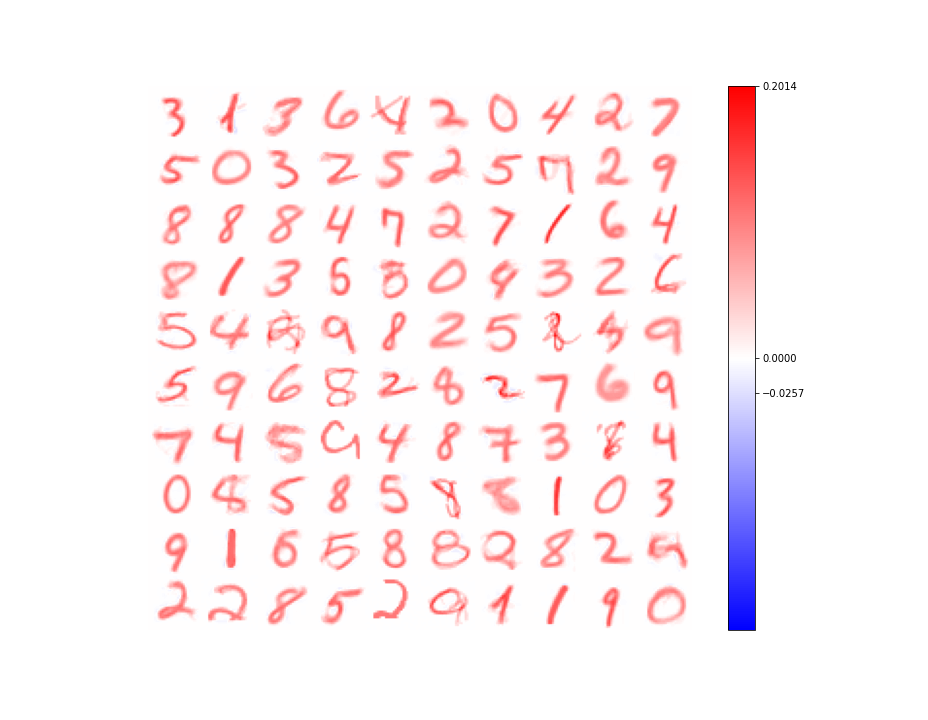

(2000, 784)
[[ 2.5223372e-44  6.8663625e-44 -5.4650640e-44 ...  4.7644148e-44
   3.5032462e-44 -3.5032462e-44]
 [ 4.2845765e-17  4.8482627e-17  3.8772966e-17 ...  5.9204585e-17
   9.3632868e-17 -5.6840047e-17]
 [-5.0000816e-32  1.4268280e-32 -5.3321012e-32 ... -8.4230465e-32
  -9.9107861e-33  1.1333833e-31]
 ...
 [-8.9616392e-20 -5.3285382e-20 -2.8969032e-20 ... -6.3376078e-21
  -2.8687483e-20  9.4920824e-20]
 [-2.8025969e-45 -2.8025969e-45  2.8025969e-45 ...  2.8025969e-45
  -2.8025969e-45  2.8025969e-45]
 [-2.8025969e-45  2.8025969e-45  2.8025969e-45 ... -2.8025969e-45
  -2.8025969e-45  2.8025969e-45]]
(280, 280)
torch.Size([2000, 784])
Fin


In [15]:
# Draw MNIST weights/feature detectors generated by unsupervised bio algo

# REFERENCED FROM: https://github.com/DimaKrotov/Biological_Learning
# To draw a heatmap of the weights a helper function is created

def draw_weights(synapses, Kx, Ky):
    print(synapses.shape) # (100, 784)
    print(synapses)
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    print(HM.shape) # (280, 280)
    for y in range(Ky):
        for x in range(Kx):
            
            shit = synapses[yy,:]
            shit_reshape = synapses[yy,:].reshape(28,28)
            
            #print(synapses.shape)     # (100, 784)
            #print(shit.shape)         # (784,)
            #print(shit_reshape.shape) # (28, 28)
            
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            
            #print(HM.shape)
            
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    #print("####")
    #print(HM.shape)
    #print(HM)
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw() 

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
#draw_weights(weights, Kx, Ky)
draw_weights(weights_mnist.cpu().numpy(), Kx, Ky)
print(weights_mnist.shape)
print("Fin")

In [ ]:
# RUN UNSUPERVISED 'BIO' LEARNING ALGORITHM for CIFAR

# Calculates weights for data and provided number of hidden units (given other configuration)
weights_cifar = get_unsupervised_weights(data_cifar, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                                         anti_hebbian_learning_strength, lebesgue_norm, rank)
print(weights_cifar.shape)
print(weights_cifar)

In [ ]:
# Draw CIFAR-10 weights/feature detectors generated by unsupervised bio algo

def draw_weights(synapses, Kx, Ky):
    print(synapses)
    print(synapses.shape) # (100, 3072)
    yy=0
    HM=np.zeros((32*Ky,32*Kx,3))
    print(HM.shape) # (320, 320, 3)
    for y in range(Ky):
        for x in range(Kx):

            shit = synapses[yy,:]
            shit_reshape = synapses[yy,:].reshape(3,32,32)

            #print(synapses.shape)   # (100, 3072)
            #print(shit.shape)          # (3072,)
            #print(shit_reshape.shape)  # (3, 32, 32)

            #HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            HM[y*32:(y+1)*32,x*32:(x+1)*32,:]=synapses[yy,:].reshape(32,32,3)

            #HM[z, y*32:(y+1)*32,x*32:(x+1)*32]=synapses[yy,:].reshape(3,32,32)
            yy += 1
    print("Done with the fucking loop")
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM[:,:,0],cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights_cifar, Kx, Ky)
print("Fin")

In [ ]:
# USE THIS BLOCK FOR DEBUGGING PURPOSES ONLY !!

# Contains data loading and whole bio learning in one block of code.
# Plots the feature detectors at the end of training.

# LOAD AND PREPARE DATA

print("Loading MNIST...")
mat = scipy.io.loadmat('mnist_all.mat')
print("Done loading MNIST")

Nc=10 # output nodes
N=784 # number of pixels for each image. 28x28

M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

data = M
num_samples = data.shape[0]   # 60000 training and validation examples. Number of samples
num_features = data.shape[1]  # number of pixels for each image. 28x28. Also: num_samples, num_pixels..

# ------------------------------------------------------------------------------------------------------------

# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Initialize weights to be values drawn from gaussian distribution.
synapses = np.random.normal(mu, sigma, (n_hidden, N)).astype(np.float32)
weights = torch.from_numpy(synapses).to(device)

# The external loop runs over epochs
for epoch in range(n_epochs):
    eps = learning_rate * (1 - epoch / n_epochs)
    #print(f'epoch learning rate: {eps}')
    
    # Scramble the images and values. So that when making a
    # mini batch, random values/images will be chosen on each iteration.
    random_permutation_samples = np.random.permutation(num_samples)
    shuffled_epoch_data = data[random_permutation_samples,:]
    
    # Internal loop runs over minibatches    
    for i in range(num_samples // batch_size):        
        # For every minibatch the overlap with the data (tot_input) is 
        # calculated for each data point and each hidden unit.
        mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
        mini_batch = torch.from_numpy(mini_batch).to(device)           
        mini_batch = torch.transpose(mini_batch, 0, 1)
        
        sign = torch.sign(weights)            
        W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
        # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
        tot_input_torch = torch.mm(W, mini_batch)
                
        # The sorted strengths of the activations are stored in y. 
        # The variable yl stores the activations of the post synaptic cells - 
        # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
        y_torch = torch.argsort(tot_input_torch, dim=0)            
        yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
        yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
        yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength
        
        # The variable ds is the right hand side of Eq 3        
        xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
        xx_torch = xx_torch.unsqueeze(1)                    
        xx_torch = xx_torch.repeat(1, num_features)
        ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)
        
        # Update weights
        # The weights are updated after each minibatch in a way so that the largest update 
        # is equal to the learning rate eps at that epoch.        
        nc_torch = torch.max(torch.abs(ds_torch))
        if nc_torch < precision: 
            nc_torch = precision            
        weights += eps*(ds_torch/nc_torch)
        
        #if (i+1) % 100 == 0:
        #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')
        
    print (f'Epoch [{epoch+1}/{n_epochs}]')
    #draw_weights(weights.numpy(), Kx, Ky)

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights.cpu().numpy(), Kx, Ky)
print("Fin")

In [ ]:
# Supervised part of bio learning algorithm
# Use weights obtained from unsupervised component
# REFERENCE: https://picnet.com.au/blog/pytorch-implementation-of-unsupervised-learning-by-competing-hidden-units-mnist-classifier/

# Describe model
class BioClassifier(nn.Module):
    # W is the unsupervised pretrained weight matrix of shape: (n_filters, img_sz)
    def __init__(self, W, out_features, n=4.5, beta=.01):
        super().__init__()
        #print(W.shape)  # (2000, 784)
        
        wtf = W.transpose(1, 0) # (img_sz, n_filters)
        #print(wtf.shape)  # (2000, 784)
        
        # This line below is incorrect because it does not perform the transpose to get the desired shape in comments.
        # Changed it to be correct.
        # self.W = W.transpose(0, 1) # (img_sz, n_filters)
        #self.W = W.transpose(1, 0) # (img_sz, n_filters)
        self.W = torch.from_numpy(W.transpose(1, 0)).to(device) # (img_sz, n_filters)
        #print(self.W.shape)
        self.n = n
        self.beta = beta
        #print(W.size)
        #print(W.shape[0])
        
        # This line below is incorrect because .size(0) written by the author is completely nonsensical.
        # Changed it to be correct.
        #self.S = nn.Linear(W.size(0), out_features, bias=False)
        self.S = nn.Linear(W.shape[0], out_features, bias=False)
        
    def forward(self, v): # v: (batch_sz, img_sz)
        #print(self.W)
        #print(self.W.shape)
        Wv = torch.matmul(v, self.W)
        
        # Author again makes a mistake in not specifiying 'F'
        #h = F.relu(Wv) ** self.n
        h = nn.functional.relu(Wv) ** self.n
        Sh = self.S(h) # Sₐᵤhᵤ == Sh
        c = torch.tanh(self.beta * Sh)
        return c
    

In [ ]:
# Loss function for supervised part of biological network
# REFERENCE: https://picnet.com.au/blog/pytorch-implementation-of-unsupervised-learning-by-competing-hidden-units-mnist-classifier/

class BioLoss(nn.Module):
    def __init__(self, out_features, m=6):
        super().__init__()
        self.out_features = out_features
        self.m = m

    def forward(self, c, t): 
        t_ohe = torch.eye(self.out_features, dtype=torch.float, device='cuda')[t]
        t_ohe[t_ohe==0] = -1.
        loss = (c - t_ohe).abs() ** self.m
        return loss.sum()
    
    # According to the hidden units paper, c = predictions, t = actual labels
    def loss(self, c, t): 
        #print("In BioLoss.loss")
        #print(f'self.out_features: {self.out_features}')
        #print(f'c.shape: {c.shape}')
        #print(f't.shape: {t.shape}')
        #print(c)
        #print(t)
        
        t_ohe = torch.eye(self.out_features, dtype=torch.float, device='cuda')[t]
        #print(f't_ohe.shape: {t_ohe.shape}')
        #print(t_ohe)
        
        t_ohe[t_ohe==0] = -1.
        #print(t_ohe)
        
        loss = (c - t_ohe).abs() ** self.m
        return loss.sum()


In [17]:
# REFERENCED FROM https://github.com/gatapia/unsupervised_bio_classifier

# Define BioClassifier classes to perform bio-plausible training

class BioCell(nn.Module):
    def __init__(self, Wui, beta, out_features):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        # TODO: Does this need to be transposed here?
        # Answer: NO! Because we are using F.linear in the forward pass rather than multiplying directly ourselves.
        # F.linear does the transpose internally.
        self.Wui = Wui
        self.beta = beta
        self.supervised = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vi):
        Wui_vi = F.linear(vi, self.Wui, None)
        # Using basic RELU 
        hu = F.relu(Wui_vi)
        Sau = self.supervised(hu)
        ca = torch.tanh(self.beta * Sau)
        return ca

    
class BioCell2(nn.Module):
    def __init__(self, Wui, beta=0.1, out_features=10):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        self.Wui = Wui.transpose(0, 1) # (768, 2000)
        self.beta = beta
        self.supervised = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vi):        
        # Different from BioCell where we do matmul here directly rather than using nn.Linear to accomplish the same.
        Wui_vi = torch.matmul(vi, self.Wui)
        # Using basic RELU 
        hu = F.relu(Wui_vi)
        Sau = self.supervised(hu)
        ca = torch.tanh(self.beta * Sau)
        return ca


class BioCell3(nn.Module):
    def __init__(self, Wui, n=4.5, beta=.01, out_features=10):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        self.Wui = Wui.transpose(0, 1) # (768, 2000)
        self.n = n
        self.beta = beta
        # Below can be renamed to self.supervised to be similar to previous cells
        self.Sau = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vᵢ):
        # vᵢ = vᵢ.view(-1, 28, 28).transpose(1, 2).contiguous().view(-1, 28*28) # change vᵢ to be HxW for testing
        Wui_vi = torch.matmul(vi, self.Wui)
        # Using custom RELU as in the paper
        hu = F.relu(Wui_vi) ** self.n
        Sau_hu = self.Sau(hu)
        ca = torch.tanh(self.beta * Sau_hu)
        return ca

    
class BioLoss(nn.Module):
    def __init__(self, m=6):
        super().__init__()
        self.m = m

    # According to the hidden units paper, c = predictions, t = actual labels
    def forward(self, c, t):
        t_ohe = torch.eye(10, dtype=torch.float, device='cuda')[t]
        t_ohe[t_ohe==0] = -1.        
        loss = (c - t_ohe).abs() ** self.m
        return loss.sum()

    
class BioClassifier(nn.Module):
    def __init__(self, bio):
        super().__init__()
        self.bio = bio

    def forward(self, vi):
        ca = self.bio(vi)
        return F.log_softmax(ca, dim=-1)



In [14]:
# RESET weights

weights_mnist = weights_mnist_frozen

In [18]:
# 0) Prepare data
# MNIST dataset 
print("Downloading MNIST data...")
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("Completed downloading MNIST data.")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Plot some sample data for sanity check
#examples = iter(test_loader)
#example_data, example_targets = examples.next()
#%matplotlib inline
#%matplotlib notebook
#for i in range(6):
#    plt.subplot(2,3,i+1)
#    plt.imshow(example_data[i][0], cmap='gray')
#plt.show()


#run_test(train_X, train_y, test_X, test_y, model, epochs, batch_size=64, lr=1e-3, verbose=0, loss=None)
#run_test(train_X, train_y, test_X, test_y, model, 300, batch_size=3584, lr=1e-4, loss=BioLoss(m=6))


# 1) Design and init model
#model = BioClassifier(BioCell2(weights_mnist)).to(device)
model = BioClassifier(BioCell3(weights_mnist)).to(device)

# Print the named parameters to test that model initialised correctly. 
# Names parameter that requires grad should be only S.weight.
print(f'Printing named parameters for the generated BioClassifier model.')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
print()

# 2) Construct loss and optimizer
criterion = BioLoss(m=6)
#criterion = nn.NLLLoss()
supervised_learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=supervised_learning_rate) 

# 3) Train the model - training loop

n_total_steps = len(train_loader)
print(f'n_total_steps: {n_total_steps}')

print('Start training...')
n_supervised_epochs = 300
print(f'n_supervised_epochs: {n_supervised_epochs}')

for epoch in range(n_supervised_epochs):
    print()
    for i, (images, labels) in enumerate(train_loader):
        
        #print(i)
        #print(images.shape)
        #print(labels.shape)
        
        # origin images shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        #print(images.shape)
        #print(labels.shape)
        #print()
        
        
        # predict = forward pass
        outputs = model(images)
        #print(f'outputs: {outputs}')

        # calculate loss
        #loss = criterion.loss(outputs, labels)
        loss = criterion(outputs, labels)
        #print(f'loss: {loss}')

        # backward pass to calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # zero autograd .grad after updating
        optimizer.zero_grad()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{n_supervised_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Completed training.')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

# OUTPUT
# Epoch [300/300], Step [600/600], Loss: 46022.9062
# Completed training.
# Accuracy of the network on the 10000 test images: 97.26 %

Completed downloading MNIST data.
Printing named parameters for the generated BioClassifier model.
bio.Sau.weight tensor([[ 0.0053,  0.0190,  0.0054,  ...,  0.0181,  0.0190, -0.0008],
        [ 0.0152,  0.0008,  0.0141,  ...,  0.0041, -0.0172, -0.0003],
        [ 0.0081, -0.0213, -0.0185,  ...,  0.0056,  0.0149,  0.0203],
        ...,
        [-0.0161, -0.0154,  0.0050,  ...,  0.0168,  0.0055, -0.0060],
        [ 0.0129, -0.0017,  0.0189,  ..., -0.0103, -0.0160, -0.0019],
        [-0.0039, -0.0098,  0.0182,  ..., -0.0053,  0.0146,  0.0217]],
       device='cuda:0')

n_total_steps: 600
Start training...
n_supervised_epochs: 300

Epoch [1/300], Step [100/600], Loss: 74746.2188
Epoch [1/300], Step [200/600], Loss: 72473.2656
Epoch [1/300], Step [300/600], Loss: 64557.2227
Epoch [1/300], Step [400/600], Loss: 62773.5000
Epoch [1/300], Step [500/600], Loss: 62307.9453
Epoch [1/300], Step [600/600], Loss: 49724.1562

Epoch [2/300], Step [100/600], Loss: 58119.3633
Epoch [2/300], Step [200/60

Epoch [26/300], Step [600/600], Loss: 36227.2266

Epoch [27/300], Step [100/600], Loss: 38148.0391
Epoch [27/300], Step [200/600], Loss: 42437.2188
Epoch [27/300], Step [300/600], Loss: 36354.3672
Epoch [27/300], Step [400/600], Loss: 40372.0156
Epoch [27/300], Step [500/600], Loss: 35699.7461
Epoch [27/300], Step [600/600], Loss: 41491.5117

Epoch [28/300], Step [100/600], Loss: 36948.7656
Epoch [28/300], Step [200/600], Loss: 42487.2383
Epoch [28/300], Step [300/600], Loss: 46924.3203
Epoch [28/300], Step [400/600], Loss: 44533.9805
Epoch [28/300], Step [500/600], Loss: 45428.6953
Epoch [28/300], Step [600/600], Loss: 41666.8438

Epoch [29/300], Step [100/600], Loss: 36610.8047
Epoch [29/300], Step [200/600], Loss: 34263.2656
Epoch [29/300], Step [300/600], Loss: 47917.7812
Epoch [29/300], Step [400/600], Loss: 40752.6875
Epoch [29/300], Step [500/600], Loss: 36108.6406
Epoch [29/300], Step [600/600], Loss: 43360.8594

Epoch [30/300], Step [100/600], Loss: 42395.9531
Epoch [30/300], 

Epoch [54/300], Step [500/600], Loss: 38635.5391
Epoch [54/300], Step [600/600], Loss: 40093.9102

Epoch [55/300], Step [100/600], Loss: 47621.9219
Epoch [55/300], Step [200/600], Loss: 43259.7109
Epoch [55/300], Step [300/600], Loss: 41195.9766
Epoch [55/300], Step [400/600], Loss: 38059.5859
Epoch [55/300], Step [500/600], Loss: 37828.6914
Epoch [55/300], Step [600/600], Loss: 48802.1094

Epoch [56/300], Step [100/600], Loss: 37771.9844
Epoch [56/300], Step [200/600], Loss: 39148.5391
Epoch [56/300], Step [300/600], Loss: 35009.8711
Epoch [56/300], Step [400/600], Loss: 37063.4453
Epoch [56/300], Step [500/600], Loss: 35512.0234
Epoch [56/300], Step [600/600], Loss: 38045.7812

Epoch [57/300], Step [100/600], Loss: 36096.4805
Epoch [57/300], Step [200/600], Loss: 34030.9688
Epoch [57/300], Step [300/600], Loss: 34860.4492
Epoch [57/300], Step [400/600], Loss: 36847.5742
Epoch [57/300], Step [500/600], Loss: 36537.5156
Epoch [57/300], Step [600/600], Loss: 36089.5078

Epoch [58/300], 

Epoch [82/300], Step [400/600], Loss: 34402.9180
Epoch [82/300], Step [500/600], Loss: 38950.6719
Epoch [82/300], Step [600/600], Loss: 35339.2969

Epoch [83/300], Step [100/600], Loss: 35961.1641
Epoch [83/300], Step [200/600], Loss: 35580.4609
Epoch [83/300], Step [300/600], Loss: 38610.8633
Epoch [83/300], Step [400/600], Loss: 42094.0312
Epoch [83/300], Step [500/600], Loss: 40829.5938
Epoch [83/300], Step [600/600], Loss: 41236.6836

Epoch [84/300], Step [100/600], Loss: 34125.0859
Epoch [84/300], Step [200/600], Loss: 37869.8047
Epoch [84/300], Step [300/600], Loss: 35076.4531
Epoch [84/300], Step [400/600], Loss: 42534.3594
Epoch [84/300], Step [500/600], Loss: 36494.8789
Epoch [84/300], Step [600/600], Loss: 37861.6758

Epoch [85/300], Step [100/600], Loss: 41307.2266
Epoch [85/300], Step [200/600], Loss: 41952.1172
Epoch [85/300], Step [300/600], Loss: 38709.9102
Epoch [85/300], Step [400/600], Loss: 36983.0547
Epoch [85/300], Step [500/600], Loss: 38421.1133
Epoch [85/300], S

Epoch [110/300], Step [200/600], Loss: 37288.2305
Epoch [110/300], Step [300/600], Loss: 40082.3047
Epoch [110/300], Step [400/600], Loss: 34469.0469
Epoch [110/300], Step [500/600], Loss: 34439.9844
Epoch [110/300], Step [600/600], Loss: 34276.2500

Epoch [111/300], Step [100/600], Loss: 34570.4766
Epoch [111/300], Step [200/600], Loss: 37618.2930
Epoch [111/300], Step [300/600], Loss: 43888.0898
Epoch [111/300], Step [400/600], Loss: 33850.2812
Epoch [111/300], Step [500/600], Loss: 37003.2344
Epoch [111/300], Step [600/600], Loss: 43841.7148

Epoch [112/300], Step [100/600], Loss: 32821.7891
Epoch [112/300], Step [200/600], Loss: 35050.7383
Epoch [112/300], Step [300/600], Loss: 42619.6094
Epoch [112/300], Step [400/600], Loss: 38818.0859
Epoch [112/300], Step [500/600], Loss: 37255.7031
Epoch [112/300], Step [600/600], Loss: 37692.6328

Epoch [113/300], Step [100/600], Loss: 40447.5391
Epoch [113/300], Step [200/600], Loss: 34750.1406
Epoch [113/300], Step [300/600], Loss: 38928.58

Epoch [137/300], Step [400/600], Loss: 34388.2617
Epoch [137/300], Step [500/600], Loss: 34160.0156
Epoch [137/300], Step [600/600], Loss: 34603.2812

Epoch [138/300], Step [100/600], Loss: 35510.1797
Epoch [138/300], Step [200/600], Loss: 39161.2969
Epoch [138/300], Step [300/600], Loss: 34473.7266
Epoch [138/300], Step [400/600], Loss: 32754.4355
Epoch [138/300], Step [500/600], Loss: 39144.5859
Epoch [138/300], Step [600/600], Loss: 34830.1953

Epoch [139/300], Step [100/600], Loss: 37781.1289
Epoch [139/300], Step [200/600], Loss: 39797.0469
Epoch [139/300], Step [300/600], Loss: 37163.4609
Epoch [139/300], Step [400/600], Loss: 38460.9062
Epoch [139/300], Step [500/600], Loss: 35341.7500
Epoch [139/300], Step [600/600], Loss: 41329.7656

Epoch [140/300], Step [100/600], Loss: 38426.2070
Epoch [140/300], Step [200/600], Loss: 34823.4961
Epoch [140/300], Step [300/600], Loss: 33005.9180
Epoch [140/300], Step [400/600], Loss: 39882.2695
Epoch [140/300], Step [500/600], Loss: 39652.10

Epoch [164/300], Step [600/600], Loss: 34102.2969

Epoch [165/300], Step [100/600], Loss: 34188.6719
Epoch [165/300], Step [200/600], Loss: 37132.5430
Epoch [165/300], Step [300/600], Loss: 34858.2422
Epoch [165/300], Step [400/600], Loss: 36617.2500
Epoch [165/300], Step [500/600], Loss: 41554.4688
Epoch [165/300], Step [600/600], Loss: 36301.2109

Epoch [166/300], Step [100/600], Loss: 35939.4102
Epoch [166/300], Step [200/600], Loss: 44850.2344
Epoch [166/300], Step [300/600], Loss: 37046.5156
Epoch [166/300], Step [400/600], Loss: 32097.7695
Epoch [166/300], Step [500/600], Loss: 39079.5312
Epoch [166/300], Step [600/600], Loss: 38270.6484

Epoch [167/300], Step [100/600], Loss: 34708.9258
Epoch [167/300], Step [200/600], Loss: 33231.9688
Epoch [167/300], Step [300/600], Loss: 36656.4102
Epoch [167/300], Step [400/600], Loss: 34973.4531
Epoch [167/300], Step [500/600], Loss: 34280.8594
Epoch [167/300], Step [600/600], Loss: 38263.4844

Epoch [168/300], Step [100/600], Loss: 40602.2

Epoch [192/300], Step [200/600], Loss: 37391.3438
Epoch [192/300], Step [300/600], Loss: 38775.1836
Epoch [192/300], Step [400/600], Loss: 38498.5703
Epoch [192/300], Step [500/600], Loss: 35608.4922
Epoch [192/300], Step [600/600], Loss: 36866.3945

Epoch [193/300], Step [100/600], Loss: 34939.7969
Epoch [193/300], Step [200/600], Loss: 33225.4414
Epoch [193/300], Step [300/600], Loss: 37972.7812
Epoch [193/300], Step [400/600], Loss: 38117.9297
Epoch [193/300], Step [500/600], Loss: 33812.8438
Epoch [193/300], Step [600/600], Loss: 36123.8477

Epoch [194/300], Step [100/600], Loss: 32473.4434
Epoch [194/300], Step [200/600], Loss: 35572.4414
Epoch [194/300], Step [300/600], Loss: 34702.2578
Epoch [194/300], Step [400/600], Loss: 33805.9609
Epoch [194/300], Step [500/600], Loss: 49144.4844
Epoch [194/300], Step [600/600], Loss: 38016.1875

Epoch [195/300], Step [100/600], Loss: 34157.6328
Epoch [195/300], Step [200/600], Loss: 35143.8594
Epoch [195/300], Step [300/600], Loss: 40982.33

Epoch [219/300], Step [400/600], Loss: 39822.8438
Epoch [219/300], Step [500/600], Loss: 32424.5195
Epoch [219/300], Step [600/600], Loss: 38292.5391

Epoch [220/300], Step [100/600], Loss: 40627.2812
Epoch [220/300], Step [200/600], Loss: 34142.9180
Epoch [220/300], Step [300/600], Loss: 36663.4336
Epoch [220/300], Step [400/600], Loss: 38058.2266
Epoch [220/300], Step [500/600], Loss: 37743.5547
Epoch [220/300], Step [600/600], Loss: 33467.9688

Epoch [221/300], Step [100/600], Loss: 32853.3594
Epoch [221/300], Step [200/600], Loss: 35804.5742
Epoch [221/300], Step [300/600], Loss: 36350.3906
Epoch [221/300], Step [400/600], Loss: 33989.2500
Epoch [221/300], Step [500/600], Loss: 34773.8828
Epoch [221/300], Step [600/600], Loss: 36020.2305

Epoch [222/300], Step [100/600], Loss: 35521.8125
Epoch [222/300], Step [200/600], Loss: 36204.9766
Epoch [222/300], Step [300/600], Loss: 40145.5781
Epoch [222/300], Step [400/600], Loss: 33089.1328
Epoch [222/300], Step [500/600], Loss: 33776.42

Epoch [246/300], Step [600/600], Loss: 35742.6055

Epoch [247/300], Step [100/600], Loss: 34803.1719
Epoch [247/300], Step [200/600], Loss: 38393.0469
Epoch [247/300], Step [300/600], Loss: 36307.9844
Epoch [247/300], Step [400/600], Loss: 35728.3711
Epoch [247/300], Step [500/600], Loss: 35802.1914
Epoch [247/300], Step [600/600], Loss: 35503.3672

Epoch [248/300], Step [100/600], Loss: 34345.5469
Epoch [248/300], Step [200/600], Loss: 34925.9766
Epoch [248/300], Step [300/600], Loss: 33366.8828
Epoch [248/300], Step [400/600], Loss: 35548.1719
Epoch [248/300], Step [500/600], Loss: 42717.6797
Epoch [248/300], Step [600/600], Loss: 40292.9141

Epoch [249/300], Step [100/600], Loss: 35426.2070
Epoch [249/300], Step [200/600], Loss: 36369.3555
Epoch [249/300], Step [300/600], Loss: 34289.5938
Epoch [249/300], Step [400/600], Loss: 33667.3359
Epoch [249/300], Step [500/600], Loss: 35604.5664
Epoch [249/300], Step [600/600], Loss: 36800.5859

Epoch [250/300], Step [100/600], Loss: 40976.0

Epoch [274/300], Step [200/600], Loss: 36124.3086
Epoch [274/300], Step [300/600], Loss: 34269.1641
Epoch [274/300], Step [400/600], Loss: 34226.7969
Epoch [274/300], Step [500/600], Loss: 34678.0703
Epoch [274/300], Step [600/600], Loss: 34943.4766

Epoch [275/300], Step [100/600], Loss: 36424.9844
Epoch [275/300], Step [200/600], Loss: 37859.0312
Epoch [275/300], Step [300/600], Loss: 39181.7617
Epoch [275/300], Step [400/600], Loss: 32930.4414
Epoch [275/300], Step [500/600], Loss: 34379.2734
Epoch [275/300], Step [600/600], Loss: 36714.1719

Epoch [276/300], Step [100/600], Loss: 33219.3125
Epoch [276/300], Step [200/600], Loss: 41327.8594
Epoch [276/300], Step [300/600], Loss: 41116.2031
Epoch [276/300], Step [400/600], Loss: 34454.1406
Epoch [276/300], Step [500/600], Loss: 33324.8672
Epoch [276/300], Step [600/600], Loss: 34281.4766

Epoch [277/300], Step [100/600], Loss: 34064.1953
Epoch [277/300], Step [200/600], Loss: 36245.3203
Epoch [277/300], Step [300/600], Loss: 37242.35

In [ ]:
# USING ignite

# 0) Prepare data
# MNIST dataset 
print("Downloading MNIST data...")
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("Completed downloading MNIST data.")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


model = BioClassifier(BioCell2(weights_mnist)).to(device)
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
# OLD

# 0) Prepare data
# MNIST dataset 
print("Downloading MNIST data...")
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("Completed downloading MNIST data.")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
examples = iter(test_loader)
example_data, example_targets = examples.next()

# Plot some sample data for sanity check
#%matplotlib inline
#%matplotlib notebook
#for i in range(6):
#    plt.subplot(2,3,i+1)
#    plt.imshow(example_data[i][0], cmap='gray')
#plt.show()


# 1) Design and init model
model = BioClassifier(weights_mnist, 10).to(device)

# Print the named parameters to test that model initialised correctly. 
# Names parameter that requires grad should be only S.weight.
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)


# 2) Construct loss and optimizer
#criterion = BioLoss(10)
criterion = nn.CrossEntropyLoss()
supervised_learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=supervised_learning_rate) 

# 3) Train the model - training loop

n_total_steps = len(train_loader)
print(f'n_total_steps: {n_total_steps}')

print('Start training...')
#for epoch in range(n_epochs):  # TODO have different number of epochs for the supervised part of training
#for epoch in range(1000):
for epoch in range(100):
    print()
    print(f'epoch: {epoch}')
    for i, (images, labels) in enumerate(train_loader):
        
        #print(i)
        #print(images.shape)
        #print(labels.shape)
        
        # origin images shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        #print(images.shape)
        #print(labels.shape)
        #print()
        
        
        # predict = forward pass
        outputs = model(images)
        #print(f'outputs: {outputs}')

        # calculate loss
        #loss = criterion.loss(outputs, labels)
        loss = criterion(outputs, labels)
        #print(f'loss: {loss}')

        # backward pass to calculate gradients
        optimizer.zero_grad() # TODO do this here or at the end of the loop?
        loss.backward()

        # update weights
        optimizer.step()

        # zero autograd .grad after updating
        # TODO here or before calling loss.backward?
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Completed training.')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')